In [1]:
from financepy.models.finite_difference import option_payoff, calculate_fd_matrix, fd_roll_backwards
from financepy.models.finite_difference_PSOR import calculate_fd_matrix
from financepy.utils import *
from financepy.market.curves import *
from financepy.products.equity import *
from financepy.models.black_scholes import *

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

%matplotlib notebook

####################################################################
# FINANCEPY BETA Version 0.270 - This build:  26 Feb 2023 at 19:12 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [2]:
option_type = OptionTypes.EUROPEAN_PUT
valuation_date = Date(1, 1, 2015)
expiry_date = valuation_date.add_years(0.5)
time_to_expiry = (expiry_date - valuation_date) / 365.0
risk_free_rate = 0.05
spot_price = 50.0
smooth = digital = False
volatility = 0.20
dividend_yield = 0.05
strike_price = 50.0

s_max = strike_price * 4
dx = 0.2
num_samples = s_max / dx

theta = 0.5

In [3]:
mu = risk_free_rate - dividend_yield

In [4]:
# time steps
num_steps = int(num_samples // 2)
dt = time_to_expiry / max(1, num_steps)

In [5]:
s = np.arange(s_max, step=dx)
payoff = option_payoff(s, strike_price, smooth, digital, option_type)

In [6]:
# Boundary condition is the payoff of the option at expiry.
# Start here and iterate backwards
res = deepcopy(payoff)[0]

# List of results at each time step, used for animation below
y = [res]

# Explicit matrix
Ae = calculate_fd_matrix(s, risk_free_rate, mu, volatility, dt, 1-theta).T
a, b, c = Ae.T

# Implicit matrix
Ai = calculate_fd_matrix(s, risk_free_rate, mu, volatility, -dt, theta).T
alpha, beta, kappa = Ai.T

# set boundary conditions at s=0 and s=infinity for each timestep
timesteps = np.arange(0, num_steps+1) * dt
if option_type in {OptionTypes.EUROPEAN_CALL, OptionTypes.AMERICAN_CALL}:
    fM = s_max - strike_price * np.exp(-risk_free_rate * (time_to_expiry - timesteps))
    f0 = f0_old = np.zeros(num_steps+1)
elif option_type in {OptionTypes.EUROPEAN_PUT, OptionTypes.AMERICAN_PUT}:
    f0 = strike_price * np.exp(-risk_free_rate * (time_to_expiry - timesteps)) - s_max
    fM = np.zeros(num_steps+1)
    
s_zero_boundary = alpha[0] * f0 - a[0] * np.roll(f0, 1)
s_infinity_boundary = kappa[-1] * fM - c[-1] * np.roll(fM, 1)

for i in range(num_steps, -1, -1):
    # Explicit step
    res = band_matrix_multiplication(Ae, 1, 1, res)
    
    # Apply boundary conditions
    res[0] += s_zero_boundary[i]
    res[-1] += s_infinity_boundary[i]
    
    # Implicit step
    res = solve_tridiagonal_matrix(Ai, res)

    # Early exit for American options
    if option_type in {OptionTypes.AMERICAN_CALL, OptionTypes.AMERICAN_PUT}:
        idx = res < payoff[0]
        res[idx] = payoff[0][idx]
    
    # Store result for animation
    y.append(res)
    
    # logging
    if not i%100:
        print(f"{i} / {num_steps}")

500 / 500
400 / 500
300 / 500
200 / 500
100 / 500
0 / 500


<IPython.core.display.Javascript object>


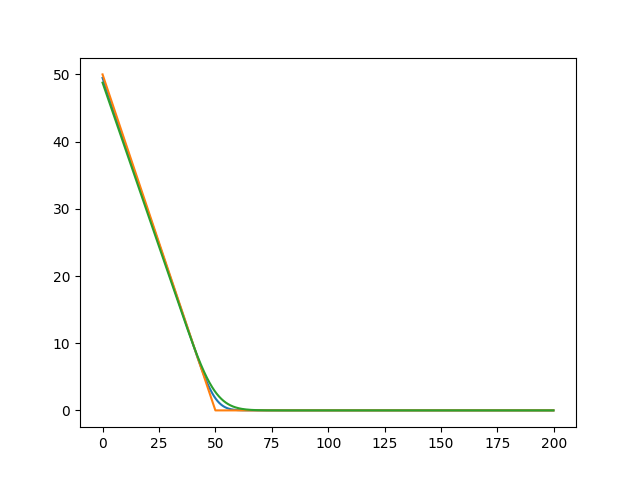

In [7]:
fig, ax = plt.subplots()
line, = ax.plot([], [])

ps = s

def animate(j):
    line.set_data((ps, y[j]))
    return line

animation_1 = animation.FuncAnimation(fig, animate, frames=len(y), interval=1)

plt.plot(ps, y[0])
plt.plot(ps, y[-1])
plt.show()

In [11]:
sample = np.argmin(np.abs(s-spot_price))
print(f"Value of option is ${y[-1][sample]:.2f}")

Value of option is $2.74
